## **Challenge Two: Build a Data Product**  

I am filtering the data and forming the data needed to work on Complaint Type Prediction.

# Data Filtering

In [1]:
# !pip install psycopg2-binary
import pandas as pd
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
pd.set_option("display.max_rows", None, "display.max_columns", None)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Function provided to access the Dataset from Redshift Database

def query_db(query):
 '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
    '''
 host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
 port = 5439
 db = 'interview'
 username = 'dsguest'
 password = 'nX9EFYUZ5Yu#0q'
 conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
 cur = conn.cursor()
 cur.execute(query)
 rows = cur.fetchall()
 column_names = [desc[0] for desc in cur.description]
 rows = pd.DataFrame(rows)
 return rows, column_names

# Analysing data for Complaint Type Prediciton

Querying the **complaint_type** and **descriptor** columns.

In [3]:
query =  """ SELECT complaint_type, descriptor
             FROM public.three_one_one 
            """
df_311, column_names = query_db(query)

# naming columns of the pandas dataframe
df_311 = df_311.rename(columns={0: column_names[0], 1: column_names[1]})

In [4]:
# Making a copy of the df
df = df_311

In [6]:
df.head()

,complaint_type,descriptor
0,PAINT - PLASTER,CEILING
1,PAINT - PLASTER,WALLS
2,PAINT - PLASTER,CEILING
3,PLUMBING,WATER-LEAKS
4,PLUMBING,WATER-LEAKS


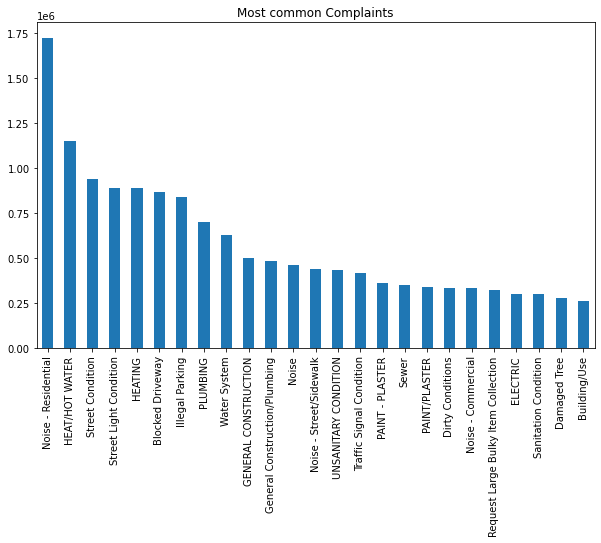

In [7]:
# Visualizing the top complaint types of the data
(df['complaint_type'].value_counts()).head(25).plot(kind='bar',
                    figsize=(10,6), title = 'Most Common Complaint Types')

The samples for the least reported are very very less compared to the most reported complaint types.  
I have decided to work on the Top 100 most reported complaint types.  

In [8]:
# Making a list of the top 100 complaint types
complaint_counts = df['complaint_type'].groupby(df['complaint_type']).count().sort_values(ascending = False).reset_index(name='count')
top_100_complaints_list = complaint_counts['complaint_type'][:100].to_list()

In [9]:
# Filtering the dataframe with top 100 complaints
boolean_series = df.complaint_type.isin(top_100_complaints_list)
filtered_df = df[boolean_series]

In [10]:
filtered_df.head()

,complaint_type,descriptor
0,PAINT - PLASTER,CEILING
1,PAINT - PLASTER,WALLS
2,PAINT - PLASTER,CEILING
3,PLUMBING,WATER-LEAKS
4,PLUMBING,WATER-LEAKS


In [ ]:
# Convering the column to string data type
filtered_df['complaint_type'] = filtered_df['complaint_type'].str.upper()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Checking for null values
filtered_df['descriptor'].isna().sum()

0

In [ ]:
# Checking for empty strings count
(filtered_df['descriptor'].values == '').sum() 

25964

In [ ]:
# drop rows with empty descriptions as these will not help us in model training
nan_value = float("NaN")
filtered_df.replace("", nan_value, inplace=True)
filtered_df.dropna(subset = ["descriptor"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Checking if we have successfully removed empty value rows
(filtered_df['descriptor'].values == '').sum() 

0

# Data Munging

Identifying similar complaint types and merging

In [ ]:
# Observing and combining similar complaint_type names
filtered_df['complaint_type'].unique()

array(['PAINT - PLASTER', 'PLUMBING', 'HEATING', 'GENERAL CONSTRUCTION',
       'NONCONST', 'ELECTRIC', 'APPLIANCE', 'NOISE - RESIDENTIAL',
       'BLOCKED DRIVEWAY', 'NOISE - COMMERCIAL', 'CONSUMER COMPLAINT',
       'MAINTENANCE OR FACILITY', 'EMERGENCY RESPONSE TEAM (ERT)',
       'TAXI COMPLAINT', 'SNOW', 'TRAFFIC SIGNAL CONDITION', 'SEWER',
       'SPECIAL PROJECTS INSPECTION TEAM (SPIT)', 'HAZARDOUS MATERIALS',
       'NOISE', 'FOR HIRE VEHICLE COMPLAINT', 'HPD LITERATURE REQUEST',
       'NOISE - STREET/SIDEWALK', 'WATER SYSTEM', 'STREET CONDITION',
       'SANITATION CONDITION', 'RODENT', 'GENERAL CONSTRUCTION/PLUMBING',
       'OTHER ENFORCEMENT', 'MISSED COLLECTION (ALL MATERIALS)',
       'DIRTY CONDITIONS', 'NEW TREE REQUEST', 'AIR QUALITY',
       'NOISE - VEHICLE', 'DOF PARKING - PAYMENT ISSUE',
       'DOF PROPERTY - OWNER ISSUE', 'BUILDING/USE',
       'NON-EMERGENCY POLICE MATTER', 'DERELICT VEHICLE',
       'BROKEN MUNI METER', 'DAMAGED TREE',
       'DHS ADVANTAGE -L

# Viewing sample similar complaint types

In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'ELECTRICAL'][:10])

      complaint_type                           descriptor
8395      ELECTRICAL  Electrical Wiring Defective/Exposed
8472      ELECTRICAL  Electrical Wiring Defective/Exposed
8483      ELECTRICAL  Electrical Wiring Defective/Exposed
8501      ELECTRICAL  Electrical Wiring Defective/Exposed
8519      ELECTRICAL  Electrical Wiring Defective/Exposed
8536      ELECTRICAL  Electrical Wiring Defective/Exposed
8807      ELECTRICAL  Electrical Wiring Defective/Exposed
8884      ELECTRICAL  Electrical Wiring Defective/Exposed
10980     ELECTRICAL  Electrical Wiring Defective/Exposed
11433     ELECTRICAL  Electrical Wiring Defective/Exposed


In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'ELECTRIC'][:10])

    complaint_type            descriptor
27        ELECTRIC       ELECTRIC-WIRING
39        ELECTRIC  BELL-BUZZER/INTERCOM
146       ELECTRIC  BELL-BUZZER/INTERCOM
147       ELECTRIC       ELECTRIC-SUPPLY
149       ELECTRIC              LIGHTING
151       ELECTRIC       ELECTRIC-SUPPLY
171       ELECTRIC       ELECTRIC-WIRING
172       ELECTRIC       ELECTRIC-WIRING
237       ELECTRIC              LIGHTING
247       ELECTRIC       ELECTRIC-SUPPLY


In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'FOR HIRE VEHICLE COMPLAINT'][:10])

                   complaint_type                     descriptor
395    FOR HIRE VEHICLE COMPLAINT  Car Service Company Complaint
396    FOR HIRE VEHICLE COMPLAINT  Car Service Company Complaint
1634   FOR HIRE VEHICLE COMPLAINT  Car Service Company Complaint
1692   FOR HIRE VEHICLE COMPLAINT  Car Service Company Complaint
2100   FOR HIRE VEHICLE COMPLAINT               Driver Complaint
4519   FOR HIRE VEHICLE COMPLAINT               Driver Complaint
4704   FOR HIRE VEHICLE COMPLAINT               Driver Complaint
8723   FOR HIRE VEHICLE COMPLAINT               Driver Complaint
10993  FOR HIRE VEHICLE COMPLAINT  Car Service Company Complaint
11860  FOR HIRE VEHICLE COMPLAINT               Driver Complaint


In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'TAXI COMPLAINT'][:10])

     complaint_type        descriptor
342  TAXI COMPLAINT  Driver Complaint
365  TAXI COMPLAINT  Driver Complaint
368  TAXI COMPLAINT  Driver Complaint
379  TAXI COMPLAINT  Driver Complaint
383  TAXI COMPLAINT  Driver Complaint
387  TAXI COMPLAINT  Driver Complaint
389  TAXI COMPLAINT  Driver Complaint
391  TAXI COMPLAINT  Driver Complaint
394  TAXI COMPLAINT  Driver Complaint
417  TAXI COMPLAINT  Driver Complaint


In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'AIR QUALITY'][:10])

     complaint_type                                   descriptor
476     AIR QUALITY        Air: Odor/Fumes, Vehicle Idling (AD3)
539     AIR QUALITY        Air: Odor/Fumes, Vehicle Idling (AD3)
578     AIR QUALITY                Air: Smoke, Residential (AA1)
589     AIR QUALITY  Air: Other Air Problem (Use Comments) (AZZ)
590     AIR QUALITY                Air: Smoke, Residential (AA1)
592     AIR QUALITY                Air: Smoke, Residential (AA1)
2123    AIR QUALITY            Air: Odor/Fumes, Restaurant (AD2)
2124    AIR QUALITY                Air: Smoke, Residential (AA1)
3851    AIR QUALITY            Air: Odor/Fumes, Restaurant (AD2)
3948    AIR QUALITY        Air: Odor/Fumes, Vehicle Idling (AD3)


In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'INDOOR AIR QUALITY'][:10])

          complaint_type                   descriptor
1948  INDOOR AIR QUALITY        Other (Explain Below)
2089  INDOOR AIR QUALITY        Other (Explain Below)
2426  INDOOR AIR QUALITY  Chemical Vapors/Gases/Odors
3993  INDOOR AIR QUALITY        Other (Explain Below)
4050  INDOOR AIR QUALITY        Other (Explain Below)
4533  INDOOR AIR QUALITY        Other (Explain Below)
4646  INDOOR AIR QUALITY                  Ventilation
5696  INDOOR AIR QUALITY        Other (Explain Below)
5763  INDOOR AIR QUALITY                  Ventilation
5826  INDOOR AIR QUALITY  Chemical Vapors/Gases/Odors


In [ ]:
print(filtered_df.loc[filtered_df['complaint_type'] == 'GENERAL'][:10])

      complaint_type          descriptor
38546        GENERAL       JANITOR/SUPER
38558        GENERAL  VENTILATION SYSTEM
38646        GENERAL  VENTILATION SYSTEM
38911        GENERAL         COOKING GAS
38931        GENERAL  VENTILATION SYSTEM
38987        GENERAL             CABINET
38991        GENERAL         COOKING GAS
39119        GENERAL             CABINET
39150        GENERAL         COOKING GAS
39218        GENERAL  VENTILATION SYSTEM


I initially tried to create a dictionary for similar complaint types, but turned out that it would be an **expensive operation** to running a for **loop over all samples**.
Hence below block of code is commented.

In [ ]:
# similar_complaint_types = dict()
# similar_complaint_types['HEATING'] = ['HEATING', 'HEAT/HOT WATER']
# similar_complaint_types['STREET CONDITION'] = ['STREET CONDITION', 'STREET LIGHT CONDITION', 
#                                      'SIDEWALK CONDITION', 'ROOT/SEWER/SIDEWALK CONDITION', 'STREET SIGN - MISSING', 'STREET SIGN - DANGLING']
# similar_complaint_types['PLUMBING'] = ['PLUMBING', 'WATER SYSTEM', 'WATER LEAK', 'STANDING WATER']
# similar_complaint_types['CONSTRUCTION'] = ['GENERAL CONSTRUCTION', 'GENERAL CONSTRUCTION/PLUMBING', 'CONSTRUCTION']
# similar_complaint_types['SANITATION'] = ['UNSANITARY CONDITION', 'DIRTY CONDITIONS', 'SANITATION CONDITION']
# similar_complaint_types['PAINT'] = ['PAINT - PLASTER', 'PAINT/PLASTER']
# similar_complaint_types['TREE'] = ['DAMAGED TREE', 'NEW TREE REQUEST', 'OVERGROWN TREE/BRANCHES', 'DEAD TREE', 'DEAD/DYING TREE', 'ILLEGAL TREE DAMAGE']
# similar_complaint_types['DERELICT VEHICLE'] = ['DERELICT VEHICLE', 'DERELICT VEHICLES']
# similar_complaint_types['TRAFFIC'] = ['TRAFFIC' + 'TRAFFIC SIGNAL CONDITION']
# similar_complaint_types['ELECTRICAL'] = ['ELECTRIC', 'ELECTRICAL']
# similar_complaint_types['TAXI'] = ['TAXI COMPLAINT', 'FOR HIRE VEHICLE COMPLAINT']
# similar_complaint_types['AIR QUALITY'] = ['AIR QUALITY', 'INDOOR AIR QUALITY']
# similar_complaint_types['OTHER'] = ['NONCONST', 'GENERAL']

Discovered that the pandas **replace** method helps with this task, given the **dictionary** in a particular format, hence wrote the following block of code:

In [ ]:
# Creating a dicitonary for associating similar complaint types, this will cut down on our classification labels and improve prediction accuracy

similar_complaint_types = dict()

# HEATING
similar_complaint_types['HEAT/HOT WATER'] = 'HEATING'

# STREET CONDITION
similar_complaint_types['STREET LIGHT CONDITION'] = 'STREET CONDITION'
similar_complaint_types['SIDEWALK CONDITION'] = 'STREET CONDITION'
similar_complaint_types['ROOT/SEWER/SIDEWALK CONDITION'] = 'STREET CONDITION'
similar_complaint_types['STREET SIGN - MISSING'] = 'STREET CONDITION'
similar_complaint_types['STREET SIGN - DANGLING'] = 'STREET CONDITION'

# PLUMBING
similar_complaint_types['WATER SYSTEM'] = "PLUMBING"
similar_complaint_types['WATER LEAK'] = "PLUMBING"
similar_complaint_types['STANDING WATER'] = "PLUMBING"

# CONSTRUCTION
similar_complaint_types['GENERAL CONSTRUCTION'] = "CONSTRUCTION"
similar_complaint_types['GENERAL CONSTRUCTION/PLUMBING'] = "CONSTRUCTION"

# SANITATION
similar_complaint_types['UNSANITARY CONDITION'] = "SANITATION"
similar_complaint_types['DIRTY CONDITIONS'] = "SANITATION"
similar_complaint_types['SANITATION CONDITION'] = "SANITATION"

# PAINT
similar_complaint_types['PAINT - PLASTER'] = "PAINT"
similar_complaint_types['PAINT/PLASTER'] = "PAINT"

# TREE
similar_complaint_types['DAMAGED TREE'] = "TREE"
similar_complaint_types['NEW TREE REQUEST'] = "TREE"
similar_complaint_types['OVERGROWN TREE/BRANCHES'] = "TREE"
similar_complaint_types['DEAD TREE'] = "TREE"
similar_complaint_types['DEAD/DYING TREE'] = "TREE"
similar_complaint_types['ILLEGAL TREE DAMAGE'] = "TREE"

# DERELICT VEHICLES
similar_complaint_types['DERELICT VEHICLES'] = "DERELICT VEHICLE"

# TRAFFIC
similar_complaint_types['TRAFFIC SIGNAL CONDITION'] = "TRAFFIC"

# ELECTRICAL
similar_complaint_types['ELECTRIC'] = "ELECTRICAL"

# TAXI
similar_complaint_types['TAXI COMPLAINT'] = "TAXI"
similar_complaint_types['FOR HIRE VEHICLE COMPLAINT'] = "TAXI"

# AIR QUALITY
similar_complaint_types['INDOOR AIR QUALITY'] = "AIR QUALITY"

# OTHER
similar_complaint_types['NONCONST'] = "OTHER"
similar_complaint_types['GENERAL'] = "OTHER"

In [ ]:
# replace function of pandas helps us to replace values with a dict
df_merged = filtered_df.replace({"complaint_type": similar_complaint_types})

In [ ]:
# saving the newly created dataframe with merged fields
df_merged.to_csv('merged_311.csv')